In [1]:
import tensorflow as tf
#import tensorflow.contrib.eager as tfe

In [2]:
#tfe.enable_eager_execution()

In [3]:
print(tf.add(1, 2))

Tensor("Add:0", shape=(), dtype=int32)


In [4]:
import numpy as np
import t3f
tf.set_random_seed(0)
np.random.seed(0)
%matplotlib inline
import matplotlib.pyplot as plt
import metric_util as mt
import data_util as du
from t3f import shapes
from nilearn import image
from skimage.measure import compare_ssim as ssim
from tensorflow.python.util import nest
import copy

/usr/local/lib/python2.7/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [5]:
print(tf.add(1, 2))

Tensor("Add_1:0", shape=(), dtype=int32)


# Tensor completion

In this example we will see how can we do tensor completion with t3f, i.e. observe a fraction of values in a tensor and recover the rest by assuming that the original tensor has low TT-rank.
Mathematically it means that we have a binary mask $P$ and a ground truth tensor $A$, but we observe only a noisy and sparsified version of $A$: $P \odot (\hat{A})$, where $\odot$ is the elementwise product (applying the binary mask) and $\hat{A} = A + \text{noise}$. In this case our task reduces to the following optimization problem:
\begin{equation*}
\begin{aligned}
& \underset{X}{\text{minimize}} 
& & \|P \odot (X - \hat{A})\|_F^2 \\
& \text{subject to} 
& & \text{tt_rank}(X) \leq r_0
\end{aligned}
\end{equation*}



### Generating problem instance,
Lets generate a random matrix $A$, noise, and mask $P$.

In [6]:
subject_scan_path = du.get_full_path_subject1()
print "Subject Path: " + str(subject_scan_path)
x_true_org = mt.read_image_abs_path(subject_scan_path)


Subject Path: /work/pl/sch/analysis/data/COBRE001/swaAMAYER+cobre01_63001+M87100944+20110309at135133+RSTpre_V01_R01+CM.nii


In [7]:
observed_ratio = 0.9
x_true_img = np.array(x_true_org.get_data())
mask_indices = (np.random.rand(x_true_img.shape[0],x_true_img.shape[1],x_true_img.shape[2], x_true_img.shape[3]) < observed_ratio).astype('int') 
ten_ones = np.ones_like(mask_indices)
x_train = copy.deepcopy(x_true_img)
x_train[mask_indices==0] = 0.0
x_train[mask_indices == 0] = np.mean(x_train[mask_indices == 1])
x_init = x_train

In [8]:
#shape = (3, 4, 4, 5, 7, 5)
shape = (53,63,46,144)
# Fix random seed so the results are comparable between runs.
tf.set_random_seed(0)
# Generate ground truth tensor A. To make sure that it has low TT-rank,
# let's generate a random tt-rank 5 tensor and apply t3f.full to it to convert to actual tensor.
#ground_truth = t3f.full(t3f.random_tensor(shape, tt_rank=5))
ground_truth = x_true_img
# Make a (non trainable) variable out of ground truth. Otherwise, it will be randomly regenerated on each sess.run.
ground_truth = tf.get_variable('ground_truth', initializer=ground_truth, trainable=False)
noise = 1e-2 * tf.get_variable('noise', initializer=tf.random_normal(shape), trainable=False)
noisy_ground_truth = ground_truth
# Observe 25% of the tensor values.
sparsity_mask = tf.cast(tf.random_uniform(shape) <= 0.60, tf.float32)
sparsity_mask = tf.get_variable('sparsity_mask', initializer=mask_indices, trainable=False)
sparsity_mask = tf.cast(sparsity_mask,tf.float32)
sparse_observation = noisy_ground_truth * sparsity_mask

In [9]:
#print ground_truth
#print sparse_observation

### Initialize the variable and compute the loss

In [10]:
def frobenius_norm_tf(x):
    return tf.reduce_sum(x ** 2) ** 0.5

In [11]:
def relative_error1(x_hat,x_true):
    percent_error = (frobenius_norm_tf(x_hat - x_true))**2 / (frobenius_norm_tf(x_true)**2)
    return percent_error

In [12]:
def tsc(x_hat,x_true, ten_ones, mask):
    nomin = np.linalg.norm(np.multiply((ten_ones - mask), (x_true - x_hat)))
    denom = np.linalg.norm(np.multiply((ten_ones - mask), x_true))
    score = nomin/denom
    return score  


In [13]:
def train_it_rel_cost(cost_hist):
    res = np.abs(cost_hist[i] - cost_hist[i-1])/np.abs(cost_hist[i-1])
    return res
    

In [14]:
observed_total = tf.reduce_sum(sparsity_mask)
total = np.prod(shape)
ranks_a = np.array([1,53,63,46,144])
tt_with_ranks = t3f.to_tt_tensor(x_true_img, max_tt_rank=144)
ranks = shapes.tt_ranks(tt_with_ranks)
initialization = t3f.random_tensor(shape, tt_rank=10)

#x_init_tf = t3f.to_tt_tensor(x_init, max_tt_rank=45) works
[53,63,46,144,1]
x_init_tf = t3f.to_tt_tensor(x_init, max_tt_rank=144)

tt_with_ranks = t3f.to_tt_tensor(x_true_img, max_tt_rank=144)
estimated = t3f.get_variable('estimated', initializer=x_init_tf)
#estimated = t3f.get_variable('estimated', initializer=initialization)
# Loss is MSE between the estimated and ground-truth tensor as computed in the observed cells.
loss = 0.5 * tf.reduce_sum((sparsity_mask * t3f.full(estimated) - sparse_observation)**2)
#ssim_loss = ssim(sparsity_mask * t3f.full(estimated), sparse_observation)
# Test loss is MSE between the estimated tensor and full (and not noisy) ground-truth tensor A.
#msssim_index = MultiScaleSSIM(sparsity_mask * t3f.full(estimated), t3f.full(estimated))
nch = tf.shape(sparse_observation)[-1]
#msssim_index = tf_ms_ssim(t3f.full(estimated), t3f.full(estimated))
#ssim_tf = tf.reduce_mean(structural_similarity(sparsity_mask * t3f.full(estimated), sparse_observation))
test_loss = 0.5 * tf.reduce_sum((t3f.full(estimated) - ground_truth)**2)
rel_error1 = relative_error1(sparsity_mask * t3f.full(estimated), sparse_observation)

[1, 53, 1, 1, 1] 0 (1, 53, 53)
[1, 53, 144, 1, 1] 1 (53, 63, 144)
[1, 53, 144, 144, 1] 2 (144, 46, 144)
ranks: [1, 53, 144, 144, 1]
[1, 53, 1, 1, 1] 0 (1, 53, 53)
[1, 53, 144, 1, 1] 1 (53, 63, 144)
[1, 53, 144, 144, 1] 2 (144, 46, 144)
ranks: [1, 53, 144, 144, 1]
[1, 53, 1, 1, 1] 0 (1, 53, 53)
[1, 53, 144, 1, 1] 1 (53, 63, 144)
[1, 53, 144, 144, 1] 2 (144, 46, 144)
ranks: [1, 53, 144, 144, 1]


# SGD optimization
The simplest way to solve the optimization problem is Stochastic Gradient Descent: let TensorFlow differentiate the loss w.r.t. the factors (cores) of the TensorTrain decomposition of the estimated tensor and minimize the loss with your favourite SGD variation.

In [15]:
np.array(ranks_a).astype(np.int32)

array([  1,  53,  63,  46, 144], dtype=int32)

In [16]:
from t3f import decompositions
shape = (2, 1, 4, 3)
np.random.seed(1)
tens = np.random.rand(*shape).astype(np.float32)
tf_tens = tf.constant(tens)
tt_tens = decompositions.to_tt_tensor(tf_tens, max_tt_rank=3)

[1, 2, 1, 1, 1] 0 (1, 2, 2)
[1, 2, 2, 1, 1] 1 (2, 1, 2)
[1, 2, 2, 3, 1] 2 (2, 4, 3)
ranks: [1, 2, 2, 3, 1]


In [17]:
print t3f.full(x_init_tf)

Tensor("Reshape_55:0", shape=(53, 63, 46, 144), dtype=float32)


In [18]:
optimizer = tf.train.AdamOptimizer(learning_rate=0.001, epsilon=1e-18)
step = optimizer.minimize(loss)

In [19]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
train_loss_hist = []
test_loss_hist = []

rel_error_hist = []

error_epsilon = 1e-5
tol = 1e-12
epsilon1=1e-12*2
sim_index_max = 0.999999
for i in range(500):
    _, tr_loss_v, test_loss_v, rel_error1_v, nch_v, ranks_v, estimated_val, ground_truth_val = sess.run([step, loss, test_loss,rel_error1, nch, ranks, t3f.full(estimated), ground_truth])
    train_loss_hist.append(tr_loss_v)
    test_loss_hist.append(test_loss_v)
    rel_error_hist.append(rel_error1_v)
    
    tsc_score = tsc(estimated_val,ground_truth_val, ten_ones, mask_indices)
    
    if i % 100 == 0:
        ssim_index = ssim(ground_truth_val, estimated_val,
                  data_range=estimated_val.max() - estimated_val.min())
        print "SSIM Index = " + str(ssim_index)
    
    if i > 1:
       diff_train = train_it_rel_cost(rel_error_hist)
       print "Train Cost Diff = " + str(diff_train)
       print "TSC Score = " + str(tsc_score)
       if diff_train<= epsilon1 or rel_error1_v<= tol or tsc_score<= error_epsilon or ssim_index>= sim_index_max:
            print("Train Cost Diff = " + str(diff_train))
            break
 
    
    
      
    print(i, tr_loss_v, test_loss_v, rel_error1_v, nch_v, ranks_v)
    #if i % 1000 == 0:
     #   print(i, tr_loss_v, test_loss_v, rel_error1_v)

SSIM Index = 0.8408338695257693
(0, 18406305000000.0, 25034690000000.0, 0.007286582, 144, array([  1,  53, 144, 144,   1], dtype=int32))
(1, 27969760000000.0, 33275867000000.0, 0.011072507, 144, array([  1,  53, 144, 144,   1], dtype=int32))
Train Cost Diff = 0.6096451
TSC Score = 0.09791149724987092
(2, 10918131000000.0, 13608163000000.0, 0.004322207, 144, array([  1,  53, 144, 144,   1], dtype=int32))
Train Cost Diff = 0.06224404
TSC Score = 0.0917511614273417
(3, 11597720000000.0, 13959822000000.0, 0.0045912387, 144, array([  1,  53, 144, 144,   1], dtype=int32))
Train Cost Diff = 0.03600954
TSC Score = 0.08793160288274912
(4, 12015348000000.0, 14184843000000.0, 0.004756567, 144, array([  1,  53, 144, 144,   1], dtype=int32))
Train Cost Diff = 0.2088537
TSC Score = 0.07928388691520213
(5, 9505898000000.0, 11269725000000.0, 0.0037631404, 144, array([  1,  53, 144, 144,   1], dtype=int32))
Train Cost Diff = 0.26632357
TSC Score = 0.07088715035835323
(6, 6974253000000.0, 8384242000000.

Train Cost Diff = 0.016054887
TSC Score = 0.009738023593033558
(50, 214113810000.0, 240720150000.0, 8.476215e-05, 144, array([  1,  53, 144, 144,   1], dtype=int32))
Train Cost Diff = 0.07222544
TSC Score = 0.010028410711626492
(51, 229578280000.0, 257795950000.0, 9.088413e-05, 144, array([  1,  53, 144, 144,   1], dtype=int32))
Train Cost Diff = 0.16634183
TSC Score = 0.010745318238052175
(52, 267766780000.0, 300163140000.0, 0.000106001964, 144, array([  1,  53, 144, 144,   1], dtype=int32))
Train Cost Diff = 0.24308147
TSC Score = 0.01186219850161863
(53, 332855900000.0, 372335050000.0, 0.00013176908, 144, array([  1,  53, 144, 144,   1], dtype=int32))
Train Cost Diff = 0.24352911
TSC Score = 0.013149714788600912
(54, 413916000000.0, 462430470000.0, 0.00016385868, 144, array([  1,  53, 144, 144,   1], dtype=int32))
Train Cost Diff = 0.06399502
TSC Score = 0.01351624669751754
(55, 440404540000.0, 491660770000.0, 0.00017434482, 144, array([  1,  53, 144, 144,   1], dtype=int32))
Train 

SSIM Index = 0.9990876660719122
Train Cost Diff = 0.0012476397
TSC Score = 0.006459148689682814
(100, 92215575000.0, 103921520000.0, 3.6505768e-05, 144, array([  1,  53, 144, 144,   1], dtype=int32))
Train Cost Diff = 0.009527208
TSC Score = 0.006429841998343614
(101, 91337010000.0, 102937035000.0, 3.615797e-05, 144, array([  1,  53, 144, 144,   1], dtype=int32))
Train Cost Diff = 0.0108729955
TSC Score = 0.006397021077707804
(102, 90343900000.0, 101825800000.0, 3.5764824e-05, 144, array([  1,  53, 144, 144,   1], dtype=int32))
Train Cost Diff = 0.0016310717
TSC Score = 0.006390289511393601
(103, 90196530000.0, 101654380000.0, 3.570649e-05, 144, array([  1,  53, 144, 144,   1], dtype=int32))
Train Cost Diff = 0.007537602
TSC Score = 0.006366673160641072
(104, 89516680000.0, 100889846000.0, 3.5437348e-05, 144, array([  1,  53, 144, 144,   1], dtype=int32))
Train Cost Diff = 0.008935684
TSC Score = 0.006339609177817755
(105, 88716796000.0, 99993590000.0, 3.512069e-05, 144, array([  1,  5

Train Cost Diff = 0.00385912
TSC Score = 0.005710820214684182
(150, 71773030000.0, 80923660000.0, 2.8413093e-05, 144, array([  1,  53, 144, 144,   1], dtype=int32))
Train Cost Diff = 0.003816517
TSC Score = 0.005700109997445434
(151, 71499100000.0, 80615460000.0, 2.8304654e-05, 144, array([  1,  53, 144, 144,   1], dtype=int32))
Train Cost Diff = 0.0038040832
TSC Score = 0.005689373595013414
(152, 71227110000.0, 80309084000.0, 2.819698e-05, 144, array([  1,  53, 144, 144,   1], dtype=int32))
Train Cost Diff = 0.0037711302
TSC Score = 0.005678736272397757
(153, 70958514000.0, 80006610000.0, 2.8090646e-05, 144, array([  1,  53, 144, 144,   1], dtype=int32))
Train Cost Diff = 0.003734638
TSC Score = 0.005668280786172669
(154, 70693500000.0, 79708260000.0, 2.7985738e-05, 144, array([  1,  53, 144, 144,   1], dtype=int32))
Train Cost Diff = 0.0037061947
TSC Score = 0.005657792615691879
(155, 70431490000.0, 79413000000.0, 2.7882017e-05, 144, array([  1,  53, 144, 144,   1], dtype=int32))
Tra

SSIM Index = 0.9986308122416128
Train Cost Diff = 0.54253906
TSC Score = 0.006858782989694306
(200, 109982100000.0, 123182340000.0, 4.353908e-05, 144, array([  1,  53, 144, 144,   1], dtype=int32))
Train Cost Diff = 0.36724254
TSC Score = 0.005576678742340911
(201, 69591990000.0, 78317620000.0, 2.7549677e-05, 144, array([  1,  53, 144, 144,   1], dtype=int32))
Train Cost Diff = 0.40389758
TSC Score = 0.006492742492721087
(202, 97700020000.0, 109528400000.0, 3.8676924e-05, 144, array([  1,  53, 144, 144,   1], dtype=int32))
Train Cost Diff = 0.3006474
TSC Score = 0.005530698928335293
(203, 68326765000.0, 76909250000.0, 2.7048807e-05, 144, array([  1,  53, 144, 144,   1], dtype=int32))
Train Cost Diff = 0.28064492
TSC Score = 0.006174226837363976
(204, 87502320000.0, 98198370000.0, 3.4639917e-05, 144, array([  1,  53, 144, 144,   1], dtype=int32))
Train Cost Diff = 0.21133162
TSC Score = 0.005553139925364438
(205, 69010320000.0, 77662560000.0, 2.7319407e-05, 144, array([  1,  53, 144, 14

Train Cost Diff = 0.0025052517
TSC Score = 0.004954297435120839
(250, 54008635000.0, 60895613000.0, 2.1380629e-05, 144, array([  1,  53, 144, 144,   1], dtype=int32))
Train Cost Diff = 0.0018174045
TSC Score = 0.004949783244411681
(251, 53910480000.0, 60784906000.0, 2.1341772e-05, 144, array([  1,  53, 144, 144,   1], dtype=int32))
Train Cost Diff = 0.0025438168
TSC Score = 0.00494326030788428
(252, 53773350000.0, 60629780000.0, 2.1287482e-05, 144, array([  1,  53, 144, 144,   1], dtype=int32))
Train Cost Diff = 0.002883042
TSC Score = 0.004936760184344893
(253, 53618307000.0, 60456670000.0, 2.122611e-05, 144, array([  1,  53, 144, 144,   1], dtype=int32))
Train Cost Diff = 0.0018872797
TSC Score = 0.0049320602692698055
(254, 53517115000.0, 60342436000.0, 2.118605e-05, 144, array([  1,  53, 144, 144,   1], dtype=int32))
Train Cost Diff = 0.0021351997
TSC Score = 0.004926915960866344
(255, 53402850000.0, 60213950000.0, 2.1140813e-05, 144, array([  1,  53, 144, 144,   1], dtype=int32))
T

SSIM Index = 0.9994949620767374
Train Cost Diff = 0.0019994979
TSC Score = 0.0047032173791985935
(300, 48611234000.0, 54817866000.0, 1.9243937e-05, 144, array([  1,  53, 144, 144,   1], dtype=int32))
Train Cost Diff = 0.001898111
TSC Score = 0.004698605589671695
(301, 48518967000.0, 54713393000.0, 1.920741e-05, 144, array([  1,  53, 144, 144,   1], dtype=int32))
Train Cost Diff = 0.0017421469
TSC Score = 0.004694633448534275
(302, 48434440000.0, 54618470000.0, 1.9173947e-05, 144, array([  1,  53, 144, 144,   1], dtype=int32))
Train Cost Diff = 0.0017548638
TSC Score = 0.004690409155668516
(303, 48349440000.0, 54522257000.0, 1.91403e-05, 144, array([  1,  53, 144, 144,   1], dtype=int32))
Train Cost Diff = 0.0018661931
TSC Score = 0.004686227931999946
(304, 48259220000.0, 54421110000.0, 1.910458e-05, 144, array([  1,  53, 144, 144,   1], dtype=int32))
Train Cost Diff = 0.0018778705
TSC Score = 0.004681646001517903
(305, 48168590000.0, 54318432000.0, 1.9068704e-05, 144, array([  1,  53, 

Train Cost Diff = 0.0018507189
TSC Score = 0.004504146097814114
(349, 44567090000.0, 50259470000.0, 1.7642962e-05, 144, array([  1,  53, 144, 144,   1], dtype=int32))
Train Cost Diff = 0.0017040368
TSC Score = 0.004500517959170449
(350, 44491145000.0, 50174407000.0, 1.7612898e-05, 144, array([  1,  53, 144, 144,   1], dtype=int32))
Train Cost Diff = 0.0016228788
TSC Score = 0.004496683570885624
(351, 44418945000.0, 50092503000.0, 1.7584314e-05, 144, array([  1,  53, 144, 144,   1], dtype=int32))
Train Cost Diff = 0.0015790706
TSC Score = 0.004493297346242918
(352, 44348793000.0, 50013856000.0, 1.7556547e-05, 144, array([  1,  53, 144, 144,   1], dtype=int32))
Train Cost Diff = 0.0015327688
TSC Score = 0.004489712868413345
(353, 44280824000.0, 49936904000.0, 1.7529637e-05, 144, array([  1,  53, 144, 144,   1], dtype=int32))
Train Cost Diff = 0.0013662938
TSC Score = 0.004486629480841294
(354, 44220326000.0, 49868653000.0, 1.7505687e-05, 144, array([  1,  53, 144, 144,   1], dtype=int32)

Train Cost Diff = 0.0015700809
TSC Score = 0.004337668194977261
(399, 41327653000.0, 46607053000.0, 1.6360553e-05, 144, array([  1,  53, 144, 144,   1], dtype=int32))
SSIM Index = 0.9995618887561069
Train Cost Diff = 0.00047585645
TSC Score = 0.004336271572102837
(400, 41307990000.0, 46583996000.0, 1.6352767e-05, 144, array([  1,  53, 144, 144,   1], dtype=int32))
Train Cost Diff = 0.00032791885
TSC Score = 0.004336521593695184
(401, 41321530000.0, 46598164000.0, 1.635813e-05, 144, array([  1,  53, 144, 144,   1], dtype=int32))
Train Cost Diff = 0.00012431924
TSC Score = 0.004336351356489816
(402, 41326674000.0, 46602895000.0, 1.6360163e-05, 144, array([  1,  53, 144, 144,   1], dtype=int32))
Train Cost Diff = 0.0007566075
TSC Score = 0.004334446159680177
(403, 41295405000.0, 46566950000.0, 1.6347785e-05, 144, array([  1,  53, 144, 144,   1], dtype=int32))
Train Cost Diff = 0.0015470737
TSC Score = 0.004331224630240761
(404, 41231510000.0, 46495265000.0, 1.6322494e-05, 144, array([  1,

Train Cost Diff = 0.0012113003
TSC Score = 0.0042036052304187796
(448, 38811840000.0, 43769848000.0, 1.536461e-05, 144, array([  1,  53, 144, 144,   1], dtype=int32))
Train Cost Diff = 0.0015423622
TSC Score = 0.004200177854146864
(449, 38751986000.0, 43701916000.0, 1.5340913e-05, 144, array([  1,  53, 144, 144,   1], dtype=int32))
Train Cost Diff = 0.0018702225
TSC Score = 0.00419661157696729
(450, 38679510000.0, 43621003000.0, 1.5312222e-05, 144, array([  1,  53, 144, 144,   1], dtype=int32))
Train Cost Diff = 0.0018854873
TSC Score = 0.004192805827558275
(451, 38606580000.0, 43539116000.0, 1.528335e-05, 144, array([  1,  53, 144, 144,   1], dtype=int32))
Train Cost Diff = 0.0015102157
TSC Score = 0.0041896970795309765
(452, 38548270000.0, 43473486000.0, 1.526027e-05, 144, array([  1,  53, 144, 144,   1], dtype=int32))
Train Cost Diff = 0.0009044723
TSC Score = 0.004187822529021338
(453, 38513410000.0, 43434220000.0, 1.5246467e-05, 144, array([  1,  53, 144, 144,   1], dtype=int32))


Train Cost Diff = 0.000636508
TSC Score = 0.004083190956901155
(498, 36612436000.0, 41290380000.0, 1.4493919e-05, 144, array([  1,  53, 144, 144,   1], dtype=int32))
Train Cost Diff = 0.00028231266
TSC Score = 0.004082055423938567
(499, 36602094000.0, 41277415000.0, 1.4489827e-05, 144, array([  1,  53, 144, 144,   1], dtype=int32))


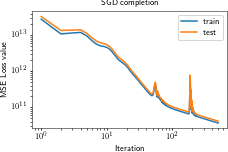

In [20]:
plt.loglog(train_loss_hist, label='train')
plt.loglog(test_loss_hist, label='test')
plt.xlabel('Iteration')
plt.ylabel('MSE Loss value')
plt.title('SGD completion')
plt.legend()


In [21]:
#ground_truth_var = t3f.get_variable('ground_truth', initializer=ground_truth, reuse=True)

In [22]:
#ground_truth.read_value()
ground_truth_val = ground_truth.eval(session=sess)

In [23]:
estimated_val = sess.run(t3f.full(estimated))

In [24]:
def relative_error(x_hat,x_true):
    percent_error = np.linalg.norm(x_hat - x_true) / np.linalg.norm(x_true)
    return percent_error

In [25]:
rel_error = relative_error(estimated_val,ground_truth_val)

In [26]:
rel_error

0.003834797

In [27]:
#ten_ones = np.ones_like(mask)
#x_reconstr = mt.reconstruct(x_hat,x_true, ten_ones, mask)

In [28]:
estimated_val.shape

(53, 63, 46, 144)

In [29]:
from nilearn import image

In [30]:
shape = (53,63,46,144)

In [31]:
sparse_observation_val=sparse_observation.eval(session=sess)

In [32]:
x_miss_img = mt.reconstruct_image_affine(x_true_org, sparse_observation_val)

In [33]:
x_miss = image.index_img(x_miss_img,1)

In [34]:
x_hat_img = mt.reconstruct_image_affine(x_true_org, estimated_val)


In [35]:
x_hat = image.index_img(x_hat_img,1)

In [36]:
from nilearn import plotting

In [37]:
x_true_org_img = image.index_img(x_true_org,1)

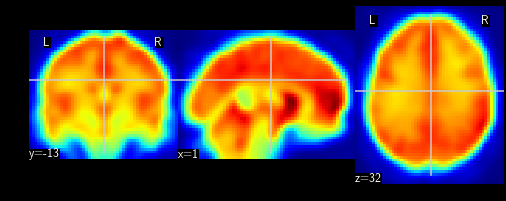

In [38]:
org_image = plotting.plot_epi(x_true_org_img, bg_img=None,black_bg=True, cmap='jet', cut_coords=None) 

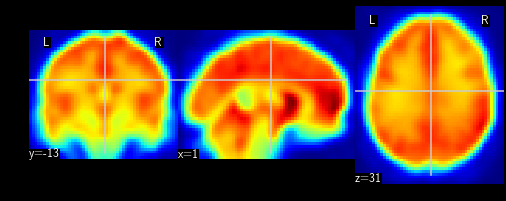

In [39]:
recovered_image = plotting.plot_epi(x_hat, bg_img=None,black_bg=True, cmap='jet', cut_coords=None) 

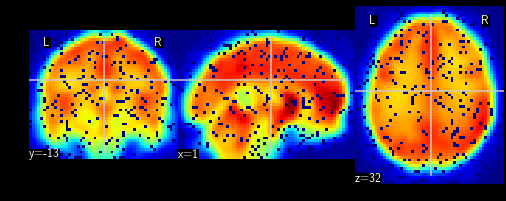

In [40]:
x_miss_image = plotting.plot_epi(x_miss, bg_img=None,black_bg=True, cmap='jet', cut_coords=None) 

In [41]:
sparse_observation_val.dtype

dtype('float32')

In [42]:
ssim_index = ssim(ground_truth_val, estimated_val,
                  data_range=estimated_val.max() - estimated_val.min())

In [43]:
print("SSIM Index = " + str(ssim_index))

SSIM Index = 0.9996077677955403


In [44]:
type(rel_error1_v)

numpy.float32

In [45]:
tsc_score = tsc(estimated_val,ground_truth_val, ten_ones, mask_indices)

In [46]:
tsc_score

0.004081574574662799